In [12]:
import pandas as pd
import numpy as np


# Generate a dataset to start with

In [14]:
np.random.seed(42)

n = 100  # number of vehicles

df = pd.DataFrame({
    'vehicle_id': [f'VEH{i:03}' for i in range(1, n+1)],
    'age_years': np.random.randint(3, 15, n),
    'mileage_km': np.random.normal(150000, 30000, n).astype(int),
    'repair_cost_usd': np.random.normal(1200, 400, n).clip(200, 5000),
    'downtime_days_last_year': np.random.poisson(5, n),
    'accident_count': np.random.poisson(0.7, n),
    'fuel_type': np.random.choice(['gasoline', 'diesel', 'electric'], n, p=[0.6, 0.1, 0.3])
})

df.head()

,vehicle_id,age_years,mileage_km,repair_cost_usd,downtime_days_last_year,accident_count,fuel_type
0,VEH001,9,148693,864.967443,2,0,gasoline
1,VEH002,6,141740,1470.874426,4,0,gasoline
2,VEH003,13,103107,1948.927647,4,1,gasoline
3,VEH004,10,126131,1358.549576,4,0,electric
4,VEH005,7,177917,949.753482,2,2,electric


In [15]:
# Add synthetic target: 1 = high exit priority
df['exit_risk_score'] = (
    0.4 * (df['mileage_km'] / df['mileage_km'].max()) +
    0.3 * (df['repair_cost_usd'] / df['repair_cost_usd'].max()) +
    0.2 * (df['downtime_days_last_year'] / df['downtime_days_last_year'].max()) +
    0.1 * df['accident_count']
)

df['exit_risk_score'] = df['exit_risk_score'].round(2)
df['is_exit_candidate'] = (df['exit_risk_score'] > 0.6).astype(int)

df.head()

,vehicle_id,age_years,mileage_km,repair_cost_usd,downtime_days_last_year,accident_count,fuel_type,exit_risk_score,is_exit_candidate
0,VEH001,9,148693,864.967443,2,0,gasoline,0.43,0
1,VEH002,6,141740,1470.874426,4,0,gasoline,0.54,0
2,VEH003,13,103107,1948.927647,4,1,gasoline,0.64,1
3,VEH004,10,126131,1358.549576,4,0,electric,0.49,0
4,VEH005,7,177917,949.753482,2,2,electric,0.70,1


# Build the model

In [16]:
# Set up the features and targets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[['age_years', 'mileage_km', 'repair_cost_usd', 'downtime_days_last_year', 'accident_count']]
y = df['is_exit_candidate']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features (optional for tree models, required for linear/logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
# Train a classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")



              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.50      0.67         8

    accuracy                           0.80        20
   macro avg       0.88      0.75      0.76        20
weighted avg       0.85      0.80      0.78        20

Accuracy: 0.800


Confusion Matrix:
[[12  0]
 [ 4  4]]


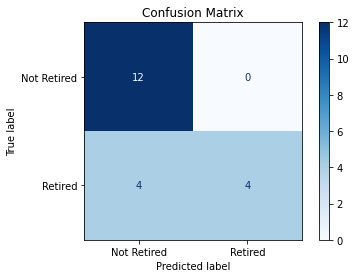

In [25]:
# Construct the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Optional: Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Retired", "Retired"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


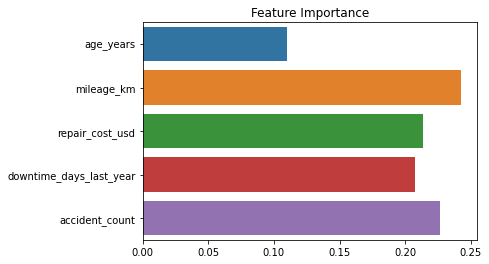

In [21]:
# Interpret the results

import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


AUC: 0.911


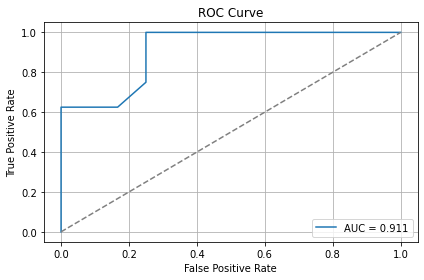

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities
y_scores = model.predict_proba(X_test)[:, 1]  # probabilities for class "1"

# Compute AUC
auc = roc_auc_score(y_test, y_scores)
print(f"AUC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
